In [1]:
import hmc_tomography
import numpy
import matplotlib.pyplot as plt

numpy.set_printoptions(precision=2, suppress=True)

/home/larsgebraad/Documents/Work/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/__init__.py:37: UserWarning: Couldn't find the required package for ElasticFullWaveform2D. Detailed errormessage: No module named '__psvWave_cpp'
  f"Couldn't find the required package for ElasticFullWaveform2D. Detailed error"


# Tutorial 1 - Gaussian inverse problems - dense forward operator


**A verification of HMC on analytically solvable forward models**

In this notebook, we'll look at sampling of inverse problems to which we have exact solutions, both the verify the validity of MCMC methods (HMC) and to illustrate how one could extend these simple problems with interesting (non-Gaussian) prior information.

<div class="alert alert-info">
<b>Note:</b> Throughout this notebook, we'll sample various distributions. Tuning settings are updated accordingly, but not discussed. Keep this in mind when playing around with the notebook; you might need to update parameters, primarily step lengths.
</div>

We will first define the model and data space size. Model parameters and data in linear forward problems are related with the following equation:


$$
\mathbf{d} = G\mathbf{m}
$$


Here, $\mathbf{d}$ and $\mathbf{m}$ are column vectors of resp. shape $[d \times 1]$ and $[m \times 1]$, and G has size $[m \times d]$. Let's start of with choosing these sizes for our illustration (feel free to experiment with these):

In [2]:
dimensions = 3
dpoints = 6

Next, we randomly generate a dense forward model operator. We are not interested in the exact values as of yet, but it is important to realise that by randomly generating values, we are not requiring G to be of full rank, i.e. (pseudo-)invertible.

In [3]:
numpy.random.seed(int(42 + numpy.random.randn()))
G = numpy.random.rand(dpoints, dimensions)

print(G, "\n\n", type(G))

[[0.25 0.05 0.68]
 [0.04 0.12 0.6 ]
 [0.19 0.67 0.92]
 [0.42 0.33 0.28]
 [0.19 0.32 0.48]
 [0.07 0.7  0.31]] 

 <class 'numpy.ndarray'>


Next we generate a 'true' model. Note that this model is sparse, only two entries are non-zero (depending what you chose for dimensions).

In [4]:
m_true = numpy.zeros((dimensions, 1))
m_true[1] = 2.0
m_true[2] = 1.0

We generate true data, but we don't do this deterministically. We directly choose to generate data with a specific noise model. This noise model is assumed known for this notebook.

The observed data is generated using the following relation:

$$
\mathbf{d}_\text{obs} = G\mathbf{m}_\text{true} + \mathbf{\sigma}
$$

Note that the added noise is also vector. We typically assume it's normally distributed (using a multivariate Gaussian):

$$
\mathbf{\sigma} \sim \mathcal{N} (\mathbf{0} , \Sigma)
$$

which makes inference in general much easier. Then the observed data constitute the noise-less observations together with a realization of this distribution.

The description of the noise may depend strongly on which datapoint we look at. There could be correlations and strong differences in standard deviation for each datum $d_i$, as captured in the covariance matrix $\Sigma$. We will first start with a diagonal (non-correlated) data covariance matrix. **NOTE**: we define data standard deviation in the next cell. To obtain $\Sigma$, we need to compute the square of the standard deviation matrix.

## Case 1: diagonal covariance matrix - no prior

In [5]:
# An array describing the noise for every datum separately
data_std = numpy.array(
    dpoints
    * [
        0.2,
    ]
)[:, None]

# Manually change one datum's noise
data_std[1] = 10.0
data_std[4] = 10.0

# Generate the data
d_obs = G @ m_true + numpy.random.randn(G.shape[0], 1) * data_std

Now we have everything we need to define our (non-regularized / prior-less) inference problem using a provided class. This object analyses the supplied objects and determines the appropriate methods (i.e. sparse vs dense $G$, dense vs diagonal $\Sigma$, etc.).

In [6]:
likelihood = hmc_tomography.Distributions.LinearMatrix(G, d_obs, data_std ** 2)

To validate sampling, we first compute the analytical posterior Gaussian. Check Tarantola (2005), page 36, example 1.38 for the relevant expressions. Note that a 'prior' is still absent, so formulas have been modified accordingly.

Because the LinearMatrix class also allows for scalar data covariance, we added (but commented out) expressions for this case

In [7]:
# Analytical results

# Covariance matrix
# COV = numpy.linalg.inv(G.T @ G / (data_std ** 2)) # Scalar data covariance
inv_data_cov = numpy.diag(1.0 / data_std[:, 0] ** 2)
COV = numpy.linalg.inv(G.T @ inv_data_cov @ G)  # Vector data covariance

# Standard deviations
SIGMA = numpy.diag(numpy.diag(COV) ** 0.5)

# Correlation structure
COR = numpy.linalg.inv(SIGMA) @ COV @ numpy.linalg.inv(SIGMA)

# Means
MEAN = COV @ G.T @ inv_data_cov @ d_obs

If you encounter the warning: `invalid value encountered in sqrt` you most likely have more model parameters than observations. In this case, your likelihood covariance matrix can not be inverted (because it is guaranteed not full rank) and we probably should add a prior term that is well behaved.

What this means in a probabilistic interpretation is that the resulting distribution has infinite support and is non-normalizable, and we should use Bayes' rule to counter this.

**Let's start sampling!**

In [8]:
hmc_tomography.Samplers.HMC().sample(
    "bin/1/dense_diagonal_covariance.h5",
    likelihood,
    mass_matrix=hmc_tomography.MassMatrices.Unit(likelihood.dimensions),
    proposals=5000,
    amount_of_steps=20,
    online_thinning=1,
    overwrite_existing_file=True,
    initial_model=m_true,
    autotuning=True,
    target_acceptance_rate=0.9,
)

sys:1: Warning: 
Silently overwriting samples file (bin/1/dense_diagonal_covariance.h5) if it exists.
/home/larsgebraad/Documents/Work/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Samplers.py:1639: UserWarning: The stepsize of the algorithm went below zero. You possibly started the algorithm in a region with extremely strong gradients. The sampler will now default to a minimum stepsize of 1e-18. If this doesn't work, and if choosing a different initial model does not make this warning go away, trysetting a smaller minimal stepsize and initial stepsize value.
  "The stepsize of the algorithm went below zero. You possibly "


Tot. acc rate: 0.00. Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Let's now compute the same quantities using the samples. The `with` construct is essential, as it closes the sample file after we exit the indent. This ensures that we don't leave open the HDF5 file. **Additionally, we'll visualize the 1d and 2d marginals of the posterior.**

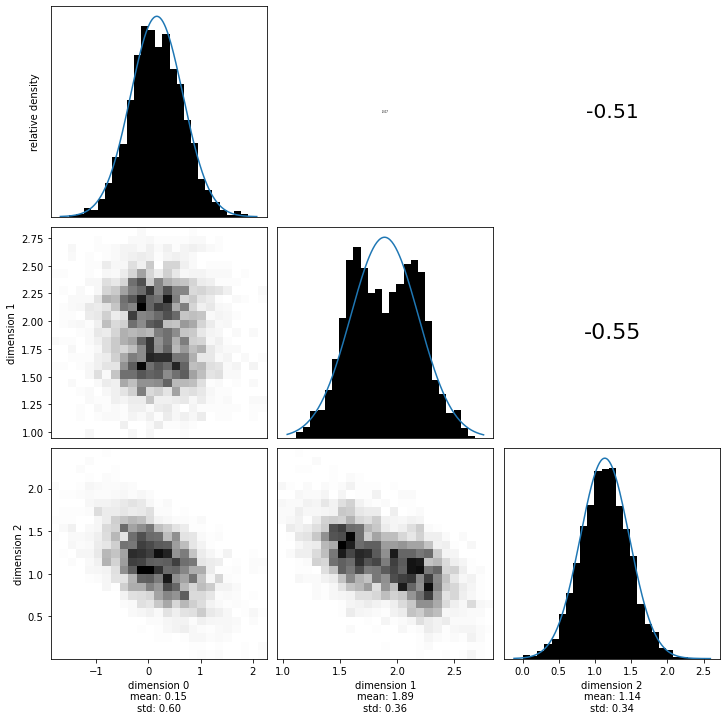

In [9]:
with hmc_tomography.Samples(
    "bin/1/dense_diagonal_covariance.h5", burn_in=1000
) as samples:

    hmc_tomography.Visualization.marginal_grid(
        samples,
        [0, 1, 2],
        figsize=(12, 12),  # Mind the ZERO INDEXED dimensions.
    )

    sampling_MEAN = numpy.mean(samples[:-1, :], axis=1)

    sampling_COV = numpy.cov(samples[:-1, :])

    sampling_SIGMA = numpy.diag(numpy.diag(sampling_COV) ** 0.5)

    sampling_COR = (
        numpy.linalg.inv(sampling_SIGMA)
        @ sampling_COV
        @ numpy.linalg.inv(sampling_SIGMA)
    )

Now we compare the posterior covariance and means of the two methods. We hope these two results are the same (as they theoretically should be), otherwise we probably made an error in the code.

We'll visualize two different things:
1. The means and variances of the sampling and analytical posteriors;
2. The full covariance matrices of the sampling and analytical posteriors.

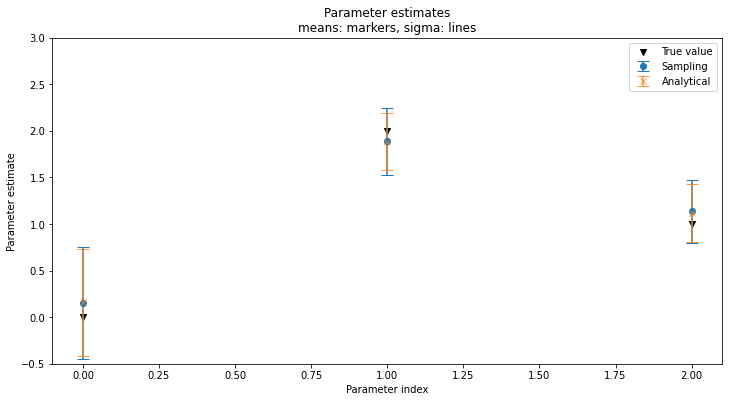

BE AWARE, I print only up to 2 digits. The sampling covariance will appear less accurate when printing more digits.

Analytical covariance matrix:
[[ 0.33 -0.01 -0.1 ]
 [-0.01  0.09 -0.06]
 [-0.1  -0.06  0.1 ]]

Sampling covariance matrix:
[[ 0.37 -0.02 -0.1 ]
 [-0.02  0.13 -0.07]
 [-0.1  -0.07  0.11]]

Difference:
[[ 0.03 -0.01 -0.  ]
 [-0.01  0.04 -0.01]
 [-0.   -0.01  0.02]]


In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(numpy.arange(m_true.size), m_true, label="True value", marker="v", color="k")


ax.errorbar(
    numpy.arange(sampling_MEAN.size),
    sampling_MEAN,
    capsize=6,
    yerr=numpy.diag(sampling_SIGMA),
    fmt="o",
    label="Sampling",
)

ax.errorbar(
    numpy.arange(MEAN.size),
    MEAN,
    capsize=6,
    yerr=numpy.diag(SIGMA),
    fmt="x",
    label="Analytical",
    alpha=0.8,
)

ax.legend()
ax.set_ylim([-0.5, 3.0])
ax.set_ylabel("Parameter estimate")
ax.set_xlabel("Parameter index")
ax.set_title("Parameter estimates\nmeans: markers, sigma: lines")
plt.show()

print(
    "BE AWARE, I print only up to 2 digits. "
    "The sampling covariance will appear less "
    "accurate when printing more digits."
)
print()
print("Analytical covariance matrix:")
print(COV)
print()
print("Sampling covariance matrix:")
print(sampling_COV)

print()
print("Difference:")
print(sampling_COV - COV)

Well, everything seems to be in order! Let's extend the theory a little bit with a dense covariance matrix.

## Case 2: dense covariance matrix - no prior

In this case, we want to encode correlations between the errors in the observed data. This may be done with normally distributed noise by adding non-diagonal entries in the covariance matrix $\Sigma$. To make life easier, we can decompose the covariance matrix (using Eigendecomposition) into variances (diagonal matrix with variances on the diagonal, $\text{diag}(\mathbf{\sigma})$) and the correlation matrix ($R$):

$$
    \Sigma = \text{diag}(\mathbf{\sigma}) \:\: R \:\:  
    \text{diag} (\mathbf{\sigma})
$$

Correlations always lie between -1 and 1, and are 1 for correlation between one parameter and itself. Both the covariance matrix and the correlation matrix have to be positive definite, otherwise the multivariate Gaussian is non-normalizable (if positive-semidefinite) or not even a proper probability (if anything else).

In [11]:
# An array describing the noise for every datum separately
data_std_dense = numpy.array(
    dpoints
    * [
        0.2,
    ]
)

# Manually change one datum's noise (same as previous example)
data_std_dense[1] = 10
data_std_dense[4] = 10

data_std_dense = numpy.diag(data_std_dense)

cor = numpy.eye(data_std_dense.shape[0])

for i in range(data_std_dense.shape[0]):
    for diff in range(int(data_std_dense.shape[0] / 2)):
        cor[i, i - diff - 1] = 0.7 ** (diff / 5.0 + 1.0)
        cor[i - diff - 1, i] = 0.7 ** (diff / 5.0 + 1.0)

data_covariance_dense = data_std_dense @ cor @ data_std_dense

# Positive definiteness check
if numpy.all(numpy.linalg.eigvals(data_covariance_dense) > 0):
    print("Matrix is positive definite; proper covariance matrix.")
else:
    raise ValueError("Not a valid covariance matrix; not positive definite.")

# Upper cholesky decomposition to generate RNG
CHOL = numpy.linalg.cholesky(data_covariance_dense)

# Generate the data with the updated noise model
dense_d_obs = G @ m_true + CHOL @ numpy.random.randn(G.shape[0], 1)

Matrix is positive definite; proper covariance matrix.


The matrix we create is positive definite! Now let's visualize $\Sigma$ and $R$.

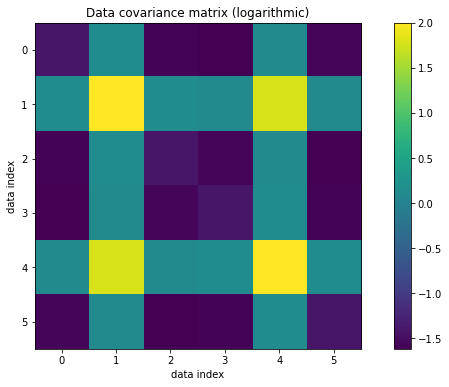

In [12]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(12, 6))

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
im = ax.imshow(numpy.log10(numpy.abs(data_covariance_dense)))
plt.title("Data covariance matrix (logarithmic)")
ax.set_xlabel("data index")
ax.set_ylabel("data index")
ax.yaxis.set_major_formatter(FormatStrFormatter("%i"))
plt.colorbar(im)

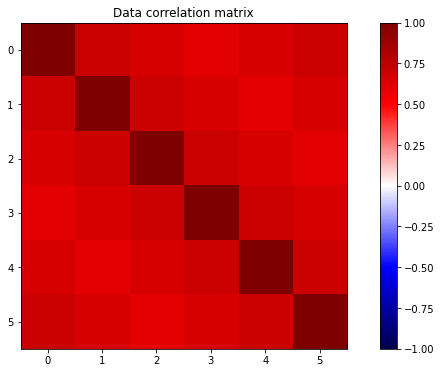

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(cor, vmin=-1, vmax=1, cmap=plt.get_cmap("seismic"))
plt.title("Data correlation matrix")
cbar = plt.colorbar()

These observations are highly correlated. Let's now construct our likelihood with this new data noise model.

In [14]:
likelihood = hmc_tomography.Distributions.LinearMatrix(
    G, dense_d_obs, data_covariance_dense
)

And compute the analytical solution of the inverse problem.

In [15]:
# Analytical results

# Covariance matrix
inv_data_cov = numpy.linalg.inv(data_covariance_dense)
dense_COV = numpy.linalg.inv(G.T @ inv_data_cov @ G)  # Vector data covariance

# Standard deviations
dense_SIGMA = numpy.diag(numpy.diag(dense_COV) ** 0.5)

# Correlation structure
dense_COR = numpy.linalg.inv(dense_SIGMA) @ dense_COV @ numpy.linalg.inv(dense_SIGMA)

# Means
dense_MEAN = dense_COV @ G.T @ inv_data_cov @ dense_d_obs

And draw samples from the likelihood.

In [16]:
hmc_tomography.Samplers.HMC().sample(
    "bin/1/dense_dense_covariance.h5",
    likelihood,
    mass_matrix=hmc_tomography.MassMatrices.Unit(likelihood.dimensions),
    proposals=5000,
    amount_of_steps=20,
    online_thinning=1,
    overwrite_existing_file=True,
    initial_model=m_true,
    autotuning=True,
    target_acceptance_rate=0.9,
)

sys:1: Warning: 
Silently overwriting samples file (bin/1/dense_dense_covariance.h5) if it exists.


Tot. acc rate: 0.00. Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Now we visualize the marginals again. Similar to the correlation matrix of the data noise, the upper right of this plot **is** the correlation matrix of the likelihood.

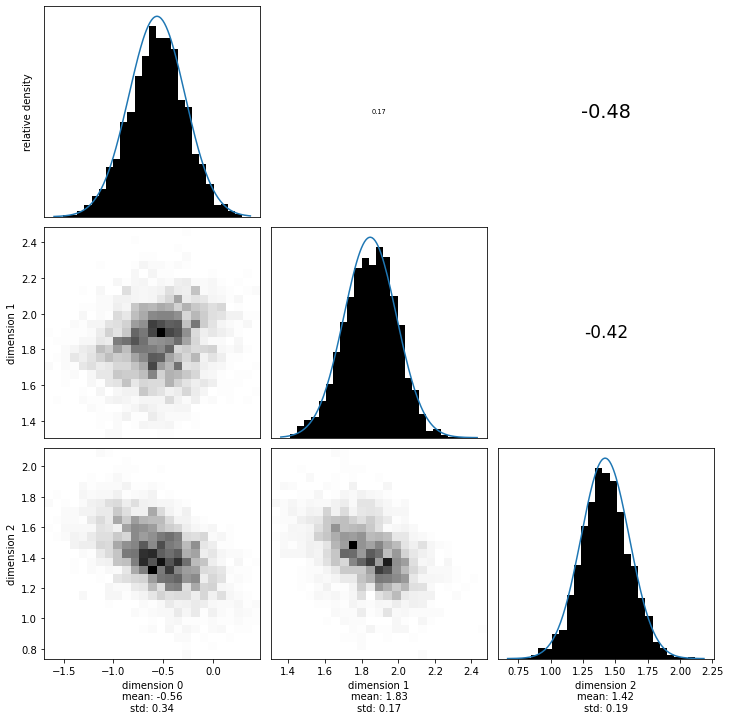

In [17]:
with hmc_tomography.Samples("bin/1/dense_dense_covariance.h5", burn_in=2000) as samples:

    hmc_tomography.Visualization.marginal_grid(
        samples,
        [0, 1, 2],
        figsize=(12, 12),  # Mind the ZERO INDEXED dimensions.
    )

    sampling_dense_MEAN = numpy.mean(samples[:-1, :], axis=1)

    sampling_dense_COV = numpy.cov(samples[:-1, :])

    sampling_dense_SIGMA = numpy.diag(numpy.diag(sampling_dense_COV) ** 0.5)

    sampling_dense_COR = (
        numpy.linalg.inv(sampling_dense_SIGMA)
        @ sampling_dense_COV
        @ numpy.linalg.inv(sampling_dense_SIGMA)
    )

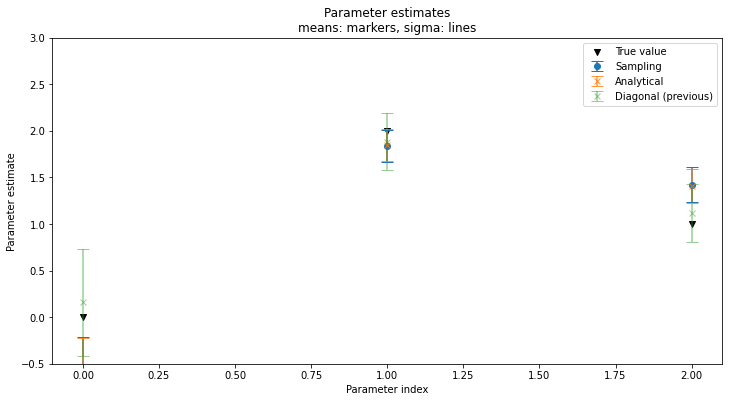

BE AWARE, I print only up to 2 digits. The sampling covariance will appear less accurate when printing more digits.

Analytical covariance matrix:
[[ 0.11  0.01 -0.03]
 [ 0.01  0.03 -0.02]
 [-0.03 -0.02  0.03]]

Sampling covariance matrix:
[[ 0.12  0.01 -0.03]
 [ 0.01  0.03 -0.01]
 [-0.03 -0.01  0.03]]

Difference:
[[0.01 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]


In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(
    numpy.arange(m_true.size),
    m_true,
    label="True value",
    marker="v",
    color="k",
)

ax.errorbar(
    numpy.arange(sampling_dense_MEAN.size),
    sampling_dense_MEAN,
    yerr=numpy.diag(sampling_dense_SIGMA),
    fmt="o",
    capsize=6,
    label="Sampling",
)

ax.errorbar(
    numpy.arange(dense_MEAN.size),
    dense_MEAN,
    yerr=numpy.diag(dense_SIGMA),
    fmt="x",
    capsize=6,
    label="Analytical",
    alpha=0.8,
)

ax.errorbar(
    numpy.arange(MEAN.size),
    MEAN,
    yerr=numpy.diag(SIGMA),
    fmt="x",
    capsize=6,
    label="Diagonal (previous)",
    alpha=0.5,
)

ax.legend()
ax.set_ylim([-0.5, 3.0])
ax.set_ylabel("Parameter estimate")
ax.set_xlabel("Parameter index")
ax.set_title("Parameter estimates\nmeans: markers, sigma: lines")
plt.show()

print(
    "BE AWARE, I print only up to 2 digits. "
    "The sampling covariance will appear less "
    "accurate when printing more digits."
)
print()
print("Analytical covariance matrix:")
print(dense_COV)
print()
print("Sampling covariance matrix:")
print(sampling_dense_COV)

print()
print("Difference:")
print(sampling_dense_COV - dense_COV)

There is a few important observations to made from the output here:

1. The sampling variances and means are equal (to a precision proportional to the amount of samples) to the analytical solution;
2. Because the noise realization and the data **covariance** are different, the means and variances are not equal to the previous case, even though the noise **variance** for every single datum is equal;
3. The total variance (sum of variances *or* product of variances) seems to be lower in the dense covariance matrix case.

Especially point 3 was surprising to me. If there are trade-offs between datums, shouldn't we constrain the model parameters worse? It turns out, the opposite happens. Let's first look at the data covariances matrices to argument this.

In [19]:
data_covariance_dense
data_covariance_diagonal = numpy.diag(data_std[:, 0] ** 2)

print(f"Data space measure of dispersion of the noise model:")
print(
    f"Ellipsoid volume diagonal (uncorrelated noise): \t{(numpy.linalg.det(data_covariance_diagonal)):.2e}"
)
print(
    f"Ellipsoid volume dense (correlated noise): \t\t{(numpy.linalg.det(data_covariance_dense)):.2e}"
)

Data space measure of dispersion of the noise model:
Ellipsoid volume diagonal (uncorrelated noise): 	2.56e-02
Ellipsoid volume dense (correlated noise): 		4.15e-04


Maybe it may make intuitive sense now: The possible values the data have before the noise is added is proportional to this determinant, or volume, of the multivariate Gaussian. In the case of the correlated noise, the possible true data is a much more constrained volume.

Verifying these volumes on the total variability of the posteriors in model space, we see the same thing:

In [20]:
print(f"Model space measure of dispersion of the posterior:")
print(f"Ellipsoid volume uncorrelated noise: \t{(numpy.linalg.det(COV)):.2e}")
print(f"Ellipsoid volume correlated noise: \t{(numpy.linalg.det(dense_COV)):.2e}")

Model space measure of dispersion of the posterior:
Ellipsoid volume uncorrelated noise: 	8.33e-04
Ellipsoid volume correlated noise: 	4.96e-05


## Case 3: dense covariance matrix - Gaussian prior

As a final validity test, we add a Gaussian prior. In this case study, the forward operator already allows us to find all medium parameters; the inverse problem is overdetermined. When this is not the case, we actually **require** a prior that makes the inverse well-behaved.

One can again find an analytical expression of the posterior in this case in Tarantola's 2005 book, page 36. We can recycle the data covariance matrix, observed data, and likelihood function from the previous case, because the noise model did not change:

In [21]:
# Recycled variables
data_covariance_dense
dense_d_obs
likelihood

Now we can create a prior centered around zero with a given variance.

In [22]:
prior_means = numpy.zeros((likelihood.dimensions, 1))
prior_variances = 0.025 * numpy.ones((likelihood.dimensions, 1))

prior = hmc_tomography.Distributions.Normal(prior_means, prior_variances)

/home/larsgebraad/Documents/Work/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/base.py:414: Warning: Seems that you only passed a vector as the covariance matrix. It will be used as the covariance diagonal.
  Warning,


Now, applying Bayes' rule without normalization is extremely easy (note that this works on more than 2 distributions simultaneously too):

In [23]:
posterior = hmc_tomography.Distributions.BayesRule([prior, likelihood])

And we can compute the analytical solution again for this case.

In [24]:
# Analytical results

# Covariance matrix
inv_prior_cov = numpy.linalg.inv(numpy.diag(prior_variances[:, 0]))
inv_data_cov = numpy.linalg.inv(data_covariance_dense)
dense_COV_prior = numpy.linalg.inv(
    G.T @ inv_data_cov @ G + inv_prior_cov
)  # Vector data covariance

# Standard deviations
dense_SIGMA_prior = numpy.diag(numpy.diag(dense_COV_prior) ** 0.5)

# Correlation structure
dense_COR_prior = (
    numpy.linalg.inv(dense_SIGMA) @ dense_COV @ numpy.linalg.inv(dense_SIGMA)
)

# Means
dense_MEAN_prior = dense_COV_prior @ (
    G.T @ inv_data_cov @ dense_d_obs + inv_prior_cov @ prior_means
)

Sampling the distribution ...

In [25]:
hmc_tomography.Samplers.HMC().sample(
    "bin/1/dense_dense_covariance_with_gaussian_prior.h5",
    posterior,
    mass_matrix=hmc_tomography.MassMatrices.Unit(likelihood.dimensions),
    proposals=5000,
    amount_of_steps=20,
    online_thinning=1,
    overwrite_existing_file=True,
    initial_model=m_true,
    autotuning=True,
    target_acceptance_rate=0.9,
)

sys:1: Warning: 
Silently overwriting samples file (bin/1/dense_dense_covariance_with_gaussian_prior.h5) if it exists.
/home/larsgebraad/Documents/Work/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Samplers.py:1639: UserWarning: The stepsize of the algorithm went below zero. You possibly started the algorithm in a region with extremely strong gradients. The sampler will now default to a minimum stepsize of 1e-18. If this doesn't work, and if choosing a different initial model does not make this warning go away, trysetting a smaller minimal stepsize and initial stepsize value.
  "The stepsize of the algorithm went below zero. You possibly "


Tot. acc rate: 0.00. Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Visualizing the marginals and computing the multivariate normal attributes from the samples.

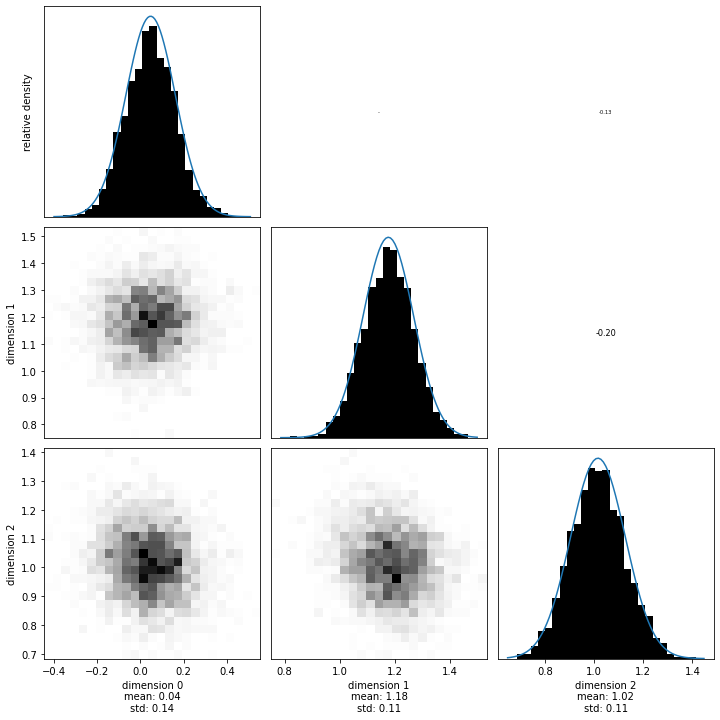

In [26]:
with hmc_tomography.Samples(
    "bin/1/dense_dense_covariance_with_gaussian_prior.h5", burn_in=1000
) as samples_posterior:

    hmc_tomography.Visualization.marginal_grid(
        samples_posterior, [0, 1, 2], figsize=(12, 12)
    )

    sampling_dense_MEAN_prior = numpy.mean(samples_posterior[:-1, :], axis=1)

    sampling_dense_COV_prior = numpy.cov(samples_posterior[:-1, :])

    sampling_dense_SIGMA_prior = numpy.diag(numpy.diag(sampling_dense_COV_prior) ** 0.5)

    sampling_dense_COR_prior = (
        numpy.linalg.inv(sampling_dense_SIGMA_prior)
        @ sampling_dense_COV_prior
        @ numpy.linalg.inv(sampling_dense_SIGMA_prior)
    )

Now we compare three things again:

1. The analytical result
2. The sampling result
3. The result of the non-regularized inversion

We again hope that 1 and 2 are the same. Additionally, we expect the addition of a prior to reduce the variability in the posterior, while 'pulling' model parameters to it's mean. Let's see what happens:

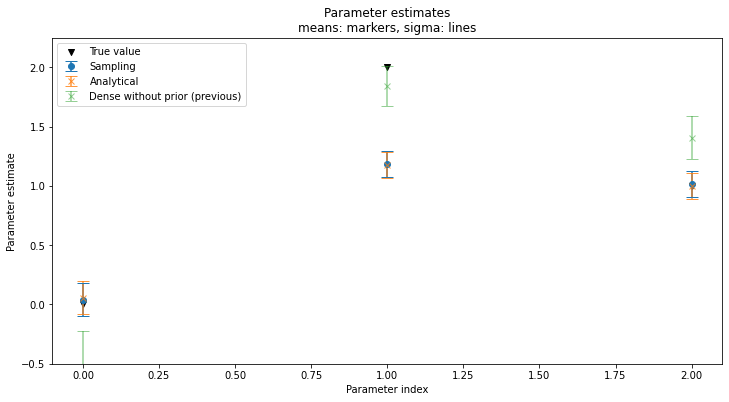

BE AWARE, I print only up to 2 digits. The sampling covariance will appear less accurate when printing more digits.

Analytical covariance matrix:
[[ 0.02 -0.   -0.  ]
 [-0.    0.01 -0.  ]
 [-0.   -0.    0.01]]

Sampling covariance matrix:
[[ 0.02  0.   -0.  ]
 [ 0.    0.01 -0.  ]
 [-0.   -0.    0.01]]

Difference:
[[-0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(
    numpy.arange(m_true.size),
    m_true,
    label="True value",
    marker="v",
    color="k",
)

ax.errorbar(
    numpy.arange(sampling_dense_MEAN_prior.size),
    sampling_dense_MEAN_prior,
    yerr=numpy.diag(sampling_dense_SIGMA_prior),
    fmt="o",
    capsize=6,
    label="Sampling",
)

ax.errorbar(
    numpy.arange(dense_MEAN_prior.size),
    dense_MEAN_prior,
    yerr=numpy.diag(dense_SIGMA_prior),
    fmt="x",
    capsize=6,
    label="Analytical",
    alpha=0.8,
)

ax.errorbar(
    numpy.arange(dense_MEAN.size),
    dense_MEAN,
    yerr=numpy.diag(dense_SIGMA),
    fmt="x",
    capsize=6,
    label="Dense without prior (previous)",
    alpha=0.5,
)

ax.legend()
ax.set_ylim([-0.5, 2.25])
ax.set_ylabel("Parameter estimate")
ax.set_xlabel("Parameter index")
ax.set_title("Parameter estimates\nmeans: markers, sigma: lines")
plt.show()

print(
    "BE AWARE, I print only up to 2 digits. "
    "The sampling covariance will appear less "
    "accurate when printing more digits."
)
print()
print("Analytical covariance matrix:")
print(dense_COV_prior)
print()
print("Sampling covariance matrix:")
print(sampling_dense_COV_prior)

print()
print("Difference:")
print(sampling_dense_COV_prior - dense_COV_prior)

Again, our sampling corresponds to our analytical solution! The prior has two main impacts on the posterior:

1. The prior reduces variation (uncertainty) in the posterior by decreasing variances for parameters as well as tuning the correlation matrix to that of the prior. The amount the posterior correlation correspond to the prior correlation (which in this case was the identity matrix, no correlation) depends on the prior variance. Try changing it and visualizing the posterior correlation matrix (**If you do this, also remember to re-tune the algorithm!**).

2. The prior 'pulls' posterior means towards prior means. But, because there are correlations introduced through the data covariance matrix and the forward model matrix, a pull in one dimension might trade-off with a 'push' for another parameter. In more mathematical terms; in e.g. 2d, a Gaussian unit prior prefers the point (0.5, 0.5) to (1.0, 0.0).

## Case 4 - A non-Gaussian prior

In this final example we'll test the influence of using a non-Gaussian prior. In this case, we can not solve the inverse problem analytically anymore. Our comparison can now only be done to a different posterior (i.e. the posterior from the previous case) to assess the impact of the prior.

We'll use a prior that promotes sparsity. What this means, is that this prior 'prefers' solutions where many entries are zero (or many entries are at its mean, we can define what value that is). This is quantified by the Laplace distribution. In 1 dimensions it's probability density function is proportional to the exponent of the L1 distance to a mean scaled by a disperion $b$: 

$$
    \text{Laplace}(x;\: \mu, b) \propto \exp \left( - \frac{|x-\mu|}{b}  \right)
$$

By supplementing `hmc_tomography.Distributions.Laplace` with two vectors assumes `n` decoupled Laplace distributions. Next, we use Bayes' rule (in `hmc_tomography.Distributions.BayesRule`) to combine the prior and likelihood into the posterior.

In [28]:
# Create prior
means = numpy.zeros((dimensions, 1))
dispersion = 0.025 * numpy.ones((dimensions, 1))

prior_laplace = hmc_tomography.Distributions.Laplace(means, dispersion)

posterior_laplace = hmc_tomography.Distributions.BayesRule([prior_laplace, likelihood])

And we go through all the motions again:

In [29]:
hmc_tomography.Samplers.HMC().sample(
    "bin/1/dense_dense_covariance_with_laplace_prior.h5",
    posterior_laplace,
    mass_matrix=hmc_tomography.MassMatrices.Unit(likelihood.dimensions),
    proposals=5000,
    amount_of_steps=20,
    online_thinning=1,
    overwrite_existing_file=True,
    initial_model=m_true,
    autotuning=True,
    target_acceptance_rate=0.9,
)

sys:1: Warning: 
Silently overwriting samples file (bin/1/dense_dense_covariance_with_laplace_prior.h5) if it exists.
/home/larsgebraad/Documents/Work/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Samplers.py:1639: UserWarning: The stepsize of the algorithm went below zero. You possibly started the algorithm in a region with extremely strong gradients. The sampler will now default to a minimum stepsize of 1e-18. If this doesn't work, and if choosing a different initial model does not make this warning go away, trysetting a smaller minimal stepsize and initial stepsize value.
  "The stepsize of the algorithm went below zero. You possibly "


Tot. acc rate: 0.00. Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

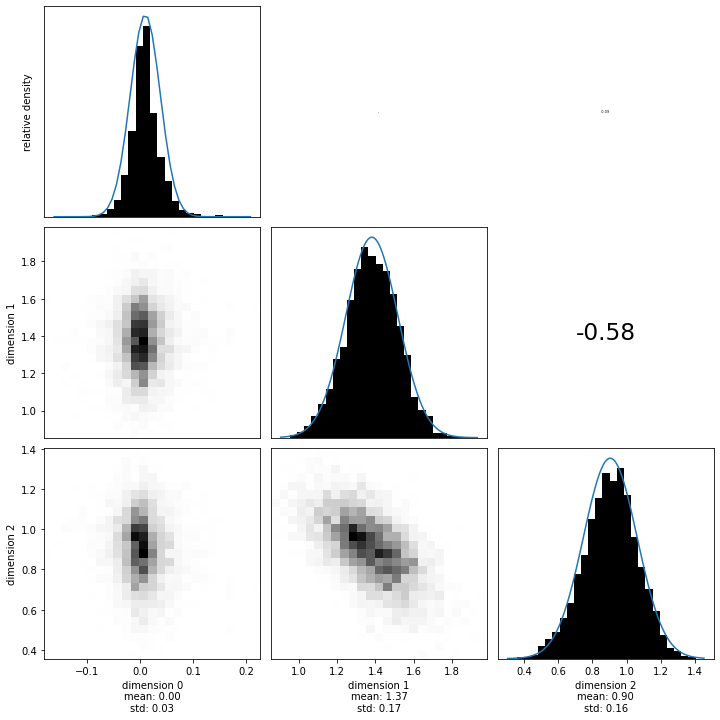

In [30]:
with hmc_tomography.Samples(
    "bin/1/dense_dense_covariance_with_laplace_prior.h5", burn_in=1000
) as samples_posterior:

    hmc_tomography.Visualization.marginal_grid(
        samples_posterior, [0, 1, 2], figsize=(12, 12)
    )

    sampling_dense_MEAN_prior_laplace = numpy.mean(samples_posterior[:-1, :], axis=1)

    sampling_dense_COV_prior_laplace = numpy.cov(samples_posterior[:-1, :])

    sampling_dense_SIGMA_prior_laplace = numpy.diag(
        numpy.diag(sampling_dense_COV_prior_laplace) ** 0.5
    )

    sampling_dense_COR_prior_laplace = (
        numpy.linalg.inv(sampling_dense_SIGMA_prior_laplace)
        @ sampling_dense_COV_prior_laplace
        @ numpy.linalg.inv(sampling_dense_SIGMA_prior_laplace)
    )

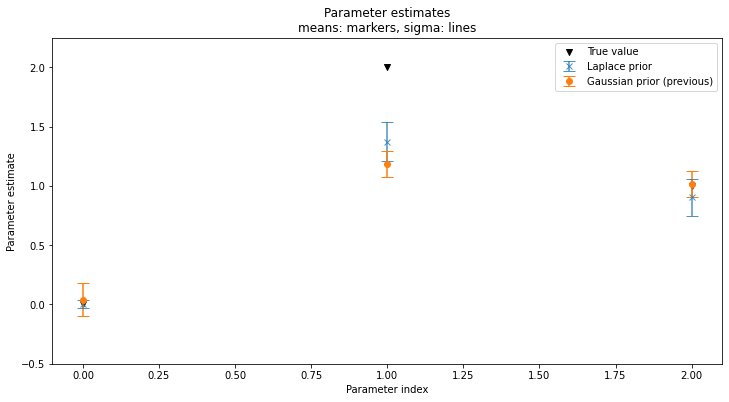

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(
    numpy.arange(m_true.size),
    m_true,
    label="True value",
    marker="v",
    color="k",
)

ax.errorbar(
    numpy.arange(sampling_dense_MEAN_prior_laplace.size),
    sampling_dense_MEAN_prior_laplace,
    yerr=numpy.diag(sampling_dense_SIGMA_prior_laplace),
    fmt="x",
    capsize=6,
    label="Laplace prior",
    alpha=0.8,
)

ax.errorbar(
    numpy.arange(sampling_dense_MEAN_prior.size),
    sampling_dense_MEAN_prior,
    yerr=numpy.diag(sampling_dense_SIGMA_prior),
    fmt="o",
    capsize=6,
    label="Gaussian prior (previous)",
)


ax.legend()
ax.set_ylim([-0.5, 2.25])
ax.set_ylabel("Parameter estimate")
ax.set_xlabel("Parameter index")
ax.set_title("Parameter estimates\nmeans: markers, sigma: lines")
plt.show()

It seems that using the Laplace prior gives us strong certainty for model parameters that are 0. Because of this, we can resolve trade-offs to other parameters better and the means of all parameters end up closer to the true solutions. This should be a logical consequence, because we added quite strong prior knowledge (our true solution is sparse) which helped to bring the posterior closer to the true solution.

We can see that for most parameters; uncertainties are lower by adding this effective prior:

In [32]:
print(numpy.diag(sampling_dense_SIGMA_prior_laplace))

print(numpy.diag(sampling_dense_SIGMA_prior))

[0.03 0.17 0.16]
[0.14 0.11 0.11]


Looking at the marginals of the two posteriors also well illustrates the non-Gaussianity, as well as the increased accuracy of the posterior.

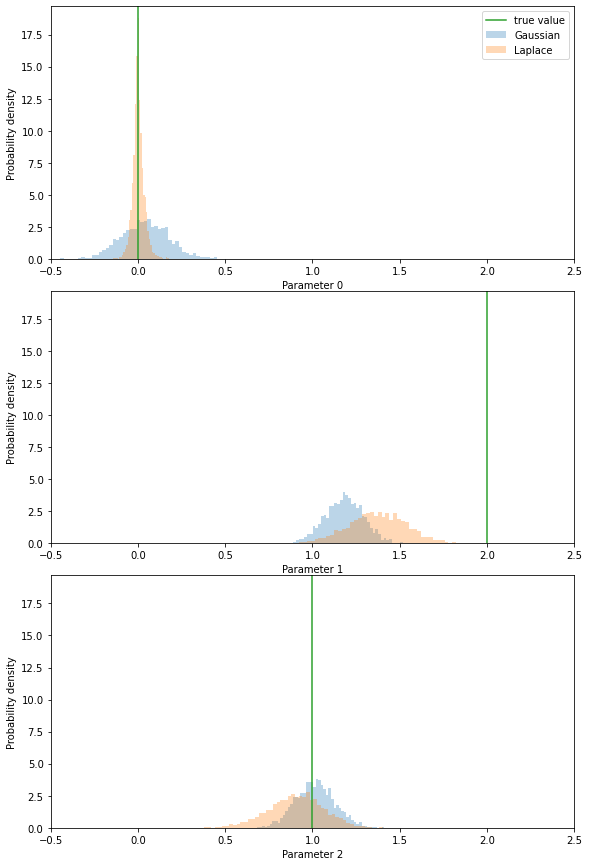

In [33]:
with hmc_tomography.Samples(
    "bin/1/dense_dense_covariance_with_laplace_prior.h5", burn_in=1000
) as samples_posterior_laplace, hmc_tomography.Samples(
    "bin/1/dense_dense_covariance_with_gaussian_prior.h5", burn_in=1000
) as samples_posterior_gaussian, hmc_tomography.Samples(
    "bin/1/dense_dense_covariance.h5", burn_in=1000
) as samples_posterior:

    fix, axes = plt.subplots(3, 1, figsize=(8, 12))

    plt.tight_layout()

    ylims = []

    for i in range(3):

        axes[i].hist(
            samples_posterior_gaussian[i, :],
            bins=50,
            label="Gaussian",
            alpha=0.3,
            density=True,
        )
        axes[i].hist(
            samples_posterior_laplace[i, :],
            bins=50,
            label="Laplace",
            alpha=0.3,
            density=True,
        )
        axes[i].set_xlim([-0.5, 2.5])
        axes[i].set_xlabel(f"Parameter {i}")
        axes[i].set_ylabel(f"Probability density")

        ylims.append(axes[i].get_ylim())

    ymax = numpy.max(numpy.array(ylims))

    for i in range(3):

        axes[i].plot([m_true[i], m_true[i]], [0, ymax], label="true value")
        axes[i].set_ylim([0, ymax])

    axes[0].legend()